In [1]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 32.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12.1
  Attempting uninstall: certifi
    Found existing installation: certifi 20

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="8OhiqM77Mv6CeutA6yAy")
project = rf.workspace("kunalkewatprojects").project("crop_disease_detection-bl93p")
version = project.version(1)
dataset = version.download("multiclass")

loading Roboflow workspace...
loading Roboflow project...


In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

2024-04-04 12:44:26.640510: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 12:44:26.640611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 12:44:26.773657: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Define data directories
train_dir = '/kaggle/working/Crop_Disease_Detection-1/train'
validation_dir = '/kaggle/working/Crop_Disease_Detection-1/valid'
test_dir = '/kaggle/working/Crop_Disease_Detection-1/test'
print('Done')

Done


In [5]:
# Load CSV files
train_csv = pd.read_csv('/kaggle/input/meta-data-cdd/train_classes.csv')
validation_csv = pd.read_csv('/kaggle/input/meta-data-cdd/validation_classes.csv')
test_csv = pd.read_csv('/kaggle/input/meta-data-cdd/test_classes.csv')
print('Done')

Done


In [6]:
# Define image size
image_size = (224, 224)
batch_size = 256
print('executed')

executed


In [7]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
print('executed')

executed


In [8]:
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_csv,
    directory=train_dir,
    x_col='filename',  # Replace 'image_filename_column' with the actual column name containing image filenames
    y_col=train_csv.columns[1:],  # Assuming class columns start from index 1, adjust if necessary
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw'  # Use 'raw' for multilabel classification
)
print('executed')

Found 20832 validated image filenames.
executed


In [10]:
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_csv,
    directory=validation_dir,
    x_col='filename',
    y_col=validation_csv.columns[1:],
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw'
)

Found 1877 validated image filenames.


In [11]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_csv,
    directory=test_dir,
    x_col='filename',
    y_col=test_csv.columns[1:],
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw'
)

Found 1168 validated image filenames.


In [12]:
# Define number of classes based on the number of columns representing classes in the CSV file
num_classes = len(train_csv.columns[1:])
print(num_classes)

47


In [13]:
# Build the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='sigmoid')(x)  # Use sigmoid activation for multilabel classification

In [16]:
model = Model(inputs=base_model.input, outputs=predictions)

In [17]:
# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = True

In [18]:
optimizer = Adam(learning_rate=0.01)

In [19]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
# Train the model
epochs = 60
history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/60


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
2024-04-04 12:47:06.613129: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[256,1024,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,2048,7,7]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-04 12:47:09.420124: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.807137101s
Trying algorithm eng0{} for conv (f32[256,1024,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,2048,7,7]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf0

27/82 ━━━━━━━━━━━━━━━━━━━━ 2:35 3s/step - accuracy: 0.2500 - loss: 0.1873

2024-04-04 12:49:56.474658: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[96,1024,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[96,2048,7,7]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-04 12:49:56.882036: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.407493866s
Trying algorithm eng0{} for conv (f32[96,1024,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[96,2048,7,7]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-04 12:49:57.921656: E external/

82/82 ━━━━━━━━━━━━━━━━━━━━ 453s 4s/step - accuracy: 0.4634 - loss: 0.1061 - val_accuracy: 0.0229 - val_loss: 0.1586
Epoch 2/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.8301 - loss: 0.0212 - val_accuracy: 0.0229 - val_loss: 0.1880
Epoch 3/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.8928 - loss: 0.0139 - val_accuracy: 0.0234 - val_loss: 0.1442
Epoch 4/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.9060 - loss: 0.0120 - val_accuracy: 0.0229 - val_loss: 0.2219
Epoch 5/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.9332 - loss: 0.0089 - val_accuracy: 0.0234 - val_loss: 0.1580
Epoch 6/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.9399 - loss: 0.0078 - val_accuracy: 0.0213 - val_loss: 0.1567
Epoch 7/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.9538 - loss: 0.0059 - val_accuracy: 0.0304 - val_loss: 0.1822
Epoch 8/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.9541 - loss: 0.0061 - val_accuracy: 0.0320 - val_loss: 0.

In [25]:
# Save the model
model.save('resnet50_model_multilabel_csv.h5')
# Save the model in native Keras format
model.save('resnet50_model_multilabel.keras')

In [22]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}\nTest accuracy: {test_accuracy}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.8132 - loss: 0.0428 
Test loss: 0.045756515115499496
Test accuracy: 0.8099315166473389


In [23]:
model.save('crop_disease_detection_model.keras')

In [115]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}\nTest accuracy: {test_accuracy}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - accuracy: 0.8482 - loss: 0.0433
Test loss: 0.04194054380059242
Test accuracy: 0.8544520735740662


In [26]:
print(history)

In [27]:
# Assuming you have a 'history' object
print("Training Loss:", history.history["loss"])
print("Validation Loss:", history.history["val_loss"])
print("Training Accuracy:", history.history["accuracy"])
print("Validation Accuracy:", history.history["val_accuracy"])

Training Loss: [0.05209330841898918, 0.019418273121118546, 0.01402880810201168, 0.011453602463006973, 0.008909102529287338, 0.007506264373660088, 0.0063048251904547215, 0.005889309104532003, 0.005067513324320316, 0.004196505527943373, 0.0035252426750957966, 0.00397792411968112, 0.0033057956025004387, 0.0029270476661622524, 0.00289740227162838, 0.0022360729053616524, 0.002148604951798916, 0.0022297499235719442, 0.0018786487635225058, 0.0026960212271660566, 0.0023408636916428804, 0.002078552730381489, 0.001948371296748519, 0.0017634604591876268, 0.0018822425045073032, 0.0014512946363538504, 0.0017849074210971594, 0.001679423381574452, 0.0011787739349529147, 0.0018264479003846645, 0.0020571521017700434, 0.0014720452018082142, 0.0007702709990553558, 0.001794066047295928, 0.0012661019572988153, 0.0011917322408407927, 0.0012908007483929396, 0.0014694883720949292, 0.0011651481036096811, 0.0012692296877503395, 0.001401668880134821, 0.0008410147856920958, 0.0009833632502704859, 0.00140260800253

In [28]:
import matplotlib.pyplot as plt

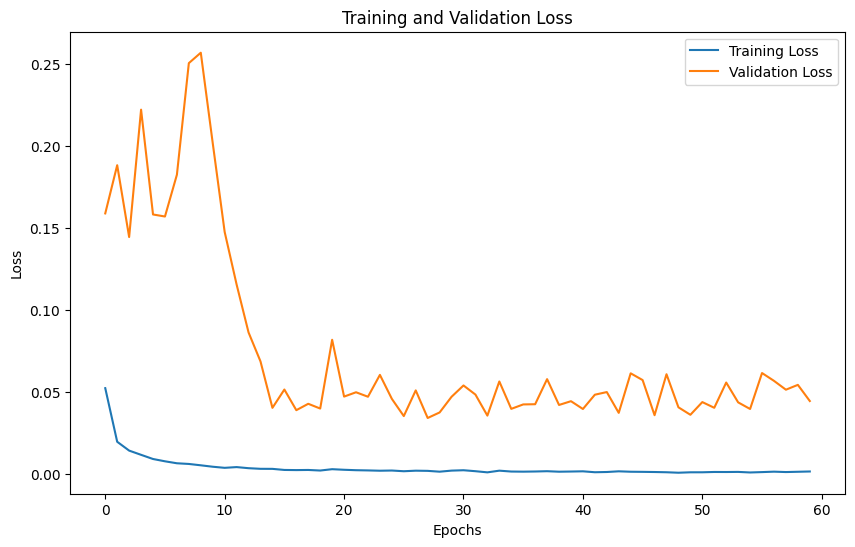

<Figure size 640x480 with 0 Axes>

In [36]:
# Assuming you have a 'history' object
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()
# Save the plot as an image file
plt.savefig('Training and Validation Loss.png')

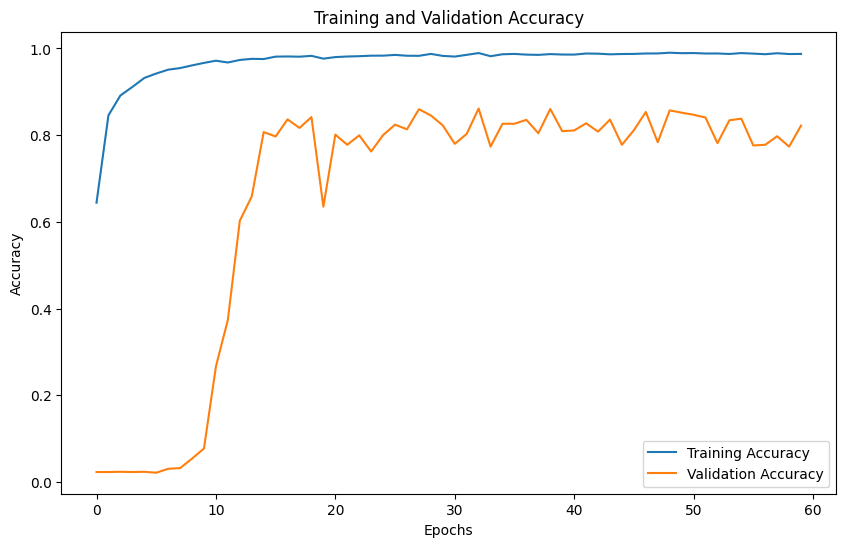

<Figure size 640x480 with 0 Axes>

In [37]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()
# Save the plot as an image file
plt.savefig('Training and Validation Accuracy.png')